Number of tickers in SP500 universe: 503


[*********************100%***********************]  503 of 503 completed


Downloaded data for 503 tickers.

Sample Mean Returns:
Ticker
A      -0.000273
AAPL   -0.000356
ABBV    0.001694
ABNB   -0.001079
ABT     0.001578
dtype: float64

Sample Covariance Matrix (first 5 rows):
Ticker         A      AAPL      ABBV      ABNB       ABT
Ticker                                                  
A       0.000257  0.000043  0.000056  0.000078  0.000048
AAPL    0.000043  0.000220  0.000010  0.000124 -0.000007
ABBV    0.000056  0.000010  0.000275 -0.000031  0.000072
ABNB    0.000078  0.000124 -0.000031  0.000663 -0.000022
ABT     0.000048 -0.000007  0.000072 -0.000022  0.000166

Sample Correlation Matrix (first 5 rows):
Ticker         A      AAPL      ABBV      ABNB       ABT
Ticker                                                  
A       1.000000  0.179043  0.209826  0.189754  0.233560
AAPL    0.179043  1.000000  0.039906  0.323958 -0.037755
ABBV    0.209826  0.039906  1.000000 -0.071758  0.336427
ABNB    0.189754  0.323958 -0.071758  1.000000 -0.066859
ABT     0.23

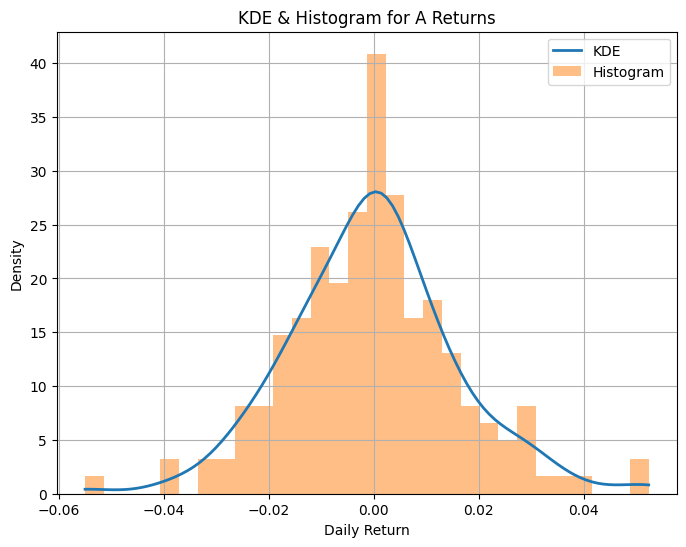

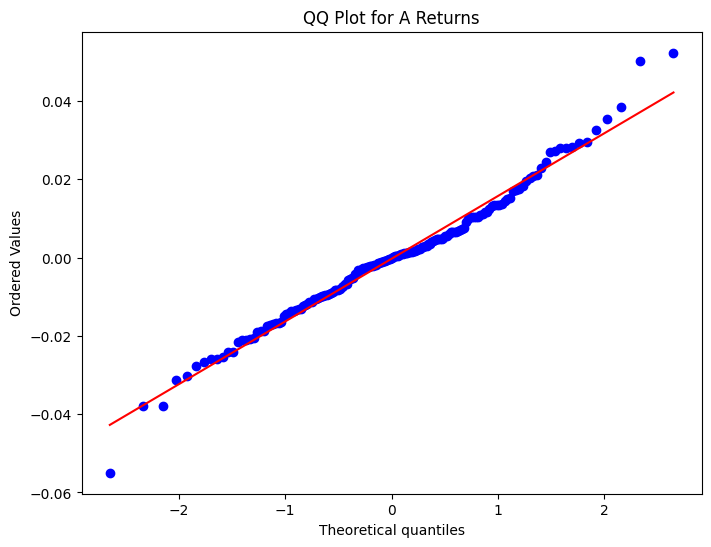

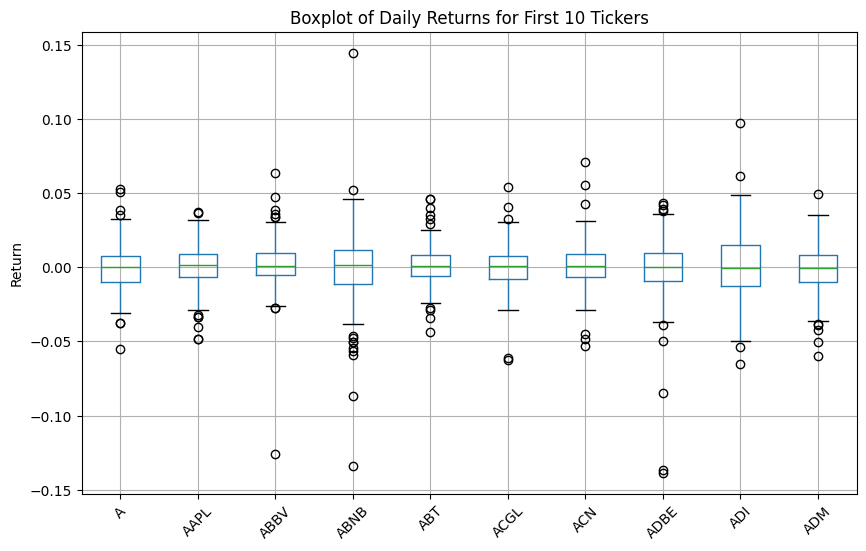

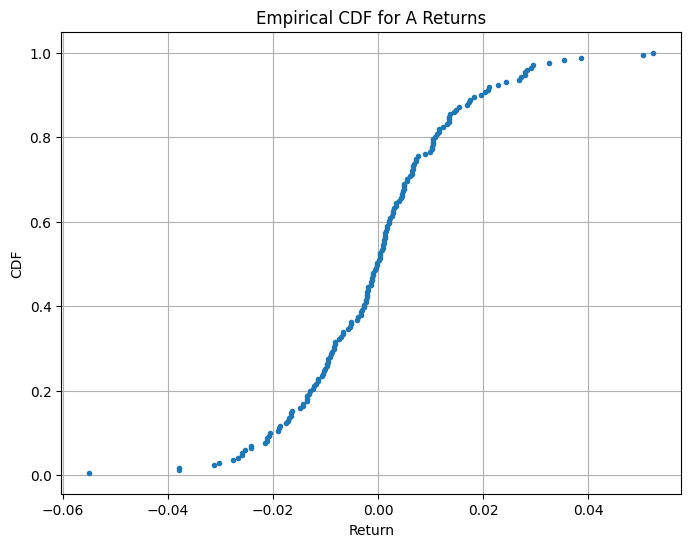

Fitted t-distribution parameters for A: df=5.85, loc=-0.0006, scale=0.0131


C:\Users\jeurc\AppData\Local\Temp\ipykernel_22584\587566280.py:123: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.006666666666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[stock] = 1.0 / len(long_stocks)
C:\Users\jeurc\AppData\Local\Temp\ipykernel_22584\587566280.py:123: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.006666666666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[stock] = 1.0 / len(long_stocks)
C:\Users\jeurc\AppData\Local\Temp\ipykernel_22584\587566280.py:123: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.006666666666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first


Rolling Portfolio Returns (sample):
2024-08-20   -0.001352
2024-08-21   -0.001106
2024-08-22   -0.000922
2024-08-23   -0.000258
2024-08-26    0.000787
dtype: float64

Annualized Sharpe Ratio of Rolling Portfolio Strategy: 1.2541
Cumulative return over rolling periods: 1.60%


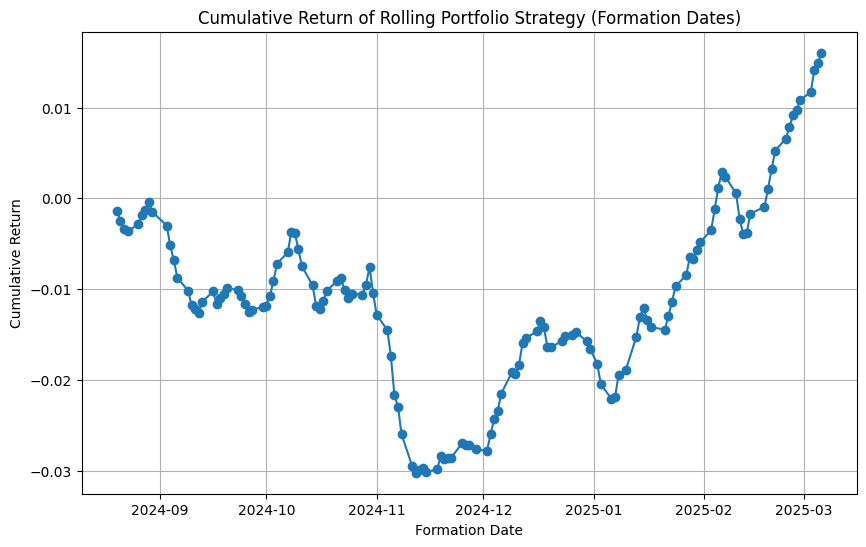

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, probplot, t, gaussian_kde
from scipy import stats

# -------------------------------
# Download 3 years of daily data for S&P500
# -------------------------------
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_tables = pd.read_html(sp500_url)
sp500_df = sp500_tables[0]
tickers = sp500_df['Symbol'].tolist()
tickers = [ticker.replace('.', '-') for ticker in tickers]
print(f"Number of tickers in SP500 universe: {len(tickers)}")

# Use 3 years of data
# data = yf.download(tickers, period='10y', interval='1d')['Close']
# data.to_parquet('sp500_10yr_daily.parquet', engine='pyarrow') 
data = pd.read_parquet('sp500_10yr_daily.parquet')
data = data.dropna(axis=1, how='all')
print(f"Downloaded data for {data.shape[1]} tickers.")

# -------------------------------
# Compute daily returns and basic distribution metrics
# -------------------------------
returns = data.pct_change().dropna()

# Mean vector, covariance, and correlation matrices
mean_returns = returns.mean()
cov_returns = returns.cov()
corr_returns = returns.corr()
print("\nSample Mean Returns:")
print(mean_returns.head())
print("\nSample Covariance Matrix (first 5 rows):")
print(cov_returns.iloc[:5, :5])
print("\nSample Correlation Matrix (first 5 rows):")
print(corr_returns.iloc[:5, :5])

# Check that covariance matrix is positive semidefinite
eigvals = np.linalg.eigvals(cov_returns)
print(f"\nMinimum eigenvalue of covariance matrix: {np.min(eigvals):.6f}")

# -------------------------------
# Exploratory plots for one sample ticker (for example purposes)
# -------------------------------
sample_ticker = returns.columns[0]
sample_series = returns[sample_ticker]

# Kernel Density Estimation and Histogram
plt.figure(figsize=(8,6))
density = np.linspace(sample_series.min(), sample_series.max(), 100)
kde = gaussian_kde(sample_series)
plt.plot(density, kde(density), label='KDE', lw=2)
plt.hist(sample_series, bins=30, density=True, alpha=0.5, label='Histogram')
plt.title(f"KDE & Histogram for {sample_ticker} Returns")
plt.xlabel("Daily Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

# QQ plot for normality
plt.figure(figsize=(8,6))
probplot(sample_series, dist="norm", plot=plt)
plt.title(f"QQ Plot for {sample_ticker} Returns")
plt.show()

# Boxplot for returns (first 10 tickers)
plt.figure(figsize=(10,6))
returns[list(returns.columns[:10])].boxplot()
plt.title("Boxplot of Daily Returns for First 10 Tickers")
plt.ylabel("Return")
plt.xticks(rotation=45)
plt.show()

# Empirical CDF for the sample ticker
sorted_returns = np.sort(sample_series)
cdf = np.arange(1, len(sorted_returns)+1) / len(sorted_returns)
plt.figure(figsize=(8,6))
plt.plot(sorted_returns, cdf, marker='.', linestyle='none')
plt.title(f"Empirical CDF for {sample_ticker} Returns")
plt.xlabel("Return")
plt.ylabel("CDF")
plt.grid(True)
plt.show()

# Fit a t-distribution to the sample returns via MLE
t_params = t.fit(sample_series)
df_est, loc_est, scale_est = t_params
print(f"Fitted t-distribution parameters for {sample_ticker}: df={df_est:.2f}, loc={loc_est:.4f}, scale={scale_est:.4f}")

# -------------------------------
# Rolling Portfolio Construction over 3 Years
# -------------------------------
formation_window = 30  # lookback window (days) to compute skewness
hold_period = 5        # hold period (days) for evaluation

portfolio_returns = []  # to store average return for each formation period
formation_dates = []    # to record formation dates

# Loop over all possible formation dates that allow a hold period
for i in range(formation_window, len(returns) - hold_period):
    formation_date = returns.index[i]
    formation_dates.append(formation_date)
    
    # Compute 30-day rolling skewness (formation period)
    formation_returns = returns.iloc[i - formation_window:i]
    skew_values = formation_returns.apply(lambda x: skew(x), axis=0).dropna()
    
    # Rank stocks by skewness (lower skew means more negative, signal for higher future returns)
    ranked = skew_values.sort_values()
    n = len(ranked)
    group_size = max(1, int(0.3 * n))
    
    # Define long (lowest 30%) and short (highest 30%) groups
    long_stocks = ranked.iloc[:group_size].index.tolist()
    short_stocks = ranked.iloc[-group_size:].index.tolist()
    
    # Create equal-weight portfolio (long-short)
    weights = pd.Series(0, index=ranked.index)
    for stock in long_stocks:
        weights[stock] = 1.0 / len(long_stocks)
    for stock in short_stocks:
        weights[stock] = -1.0 / len(short_stocks)
    
    # Evaluate portfolio returns over the next hold_period days
    hold_start = i
    hold_end = i + hold_period
    future_returns = returns.iloc[hold_start:hold_end]
    common_tickers = list(weights.index.intersection(future_returns.columns))
    if len(common_tickers) == 0:
        continue
    # Compute daily portfolio returns during the hold period
    port_ret = future_returns[common_tickers].dot(weights[common_tickers])
    # Use average daily return during the hold period as the performance metric
    avg_hold_ret = port_ret.mean()
    portfolio_returns.append(avg_hold_ret)

# Create a time series for portfolio returns
portfolio_returns_series = pd.Series(portfolio_returns, index=formation_dates[:len(portfolio_returns)])
print("\nRolling Portfolio Returns (sample):")
print(portfolio_returns_series.head())

# Compute the annualized Sharpe ratio (assume 252 trading days per year)
daily_mean = portfolio_returns_series.mean()
daily_std = portfolio_returns_series.std()
sharpe_ratio = (daily_mean / daily_std) * np.sqrt(252)
print(f"\nAnnualized Sharpe Ratio of Rolling Portfolio Strategy: {sharpe_ratio:.4f}")

# Compute cumulative return over all rolling periods (by compounding the average returns)
cumulative_return = (1 + portfolio_returns_series).prod() - 1
print(f"Cumulative return over rolling periods: {cumulative_return:.2%}")

# Plot the cumulative return curve over formation dates
cumulative_returns = (1 + portfolio_returns_series).cumprod() - 1
plt.figure(figsize=(10,6))
plt.plot(cumulative_returns.index, cumulative_returns.values, marker='o')
plt.title("Cumulative Return of Rolling Portfolio Strategy (Formation Dates)")
plt.xlabel("Formation Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()


Average Realized Skewness by Sampling Frequency:
Interval 1 minute(s): -0.0013
Interval 2 minute(s): -0.0030
Interval 5 minute(s): -0.0020
Interval 10 minute(s): -0.0043
Interval 15 minute(s): -0.0035
Interval 30 minute(s): 0.0114

Average Realized Excess Kurtosis by Sampling Frequency:
Interval 1 minute(s): 0.6168
Interval 2 minute(s): 0.4012
Interval 5 minute(s): 0.2056
Interval 10 minute(s): 0.1091
Interval 15 minute(s): 0.0624
Interval 30 minute(s): -0.0071


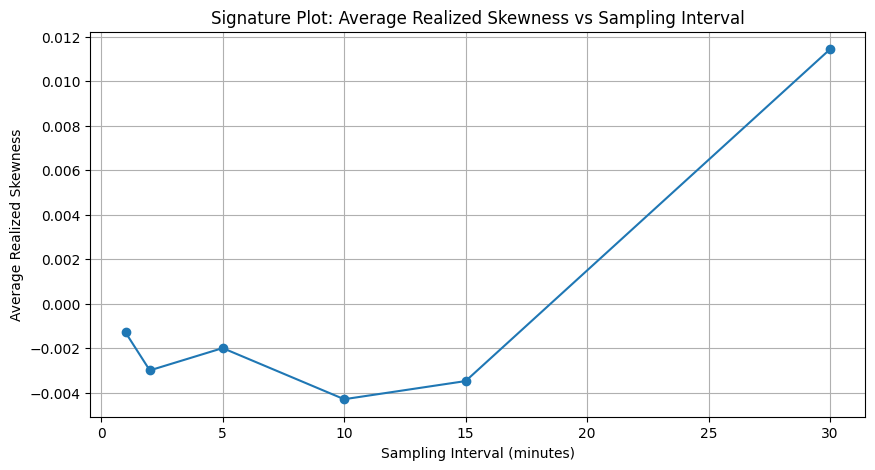

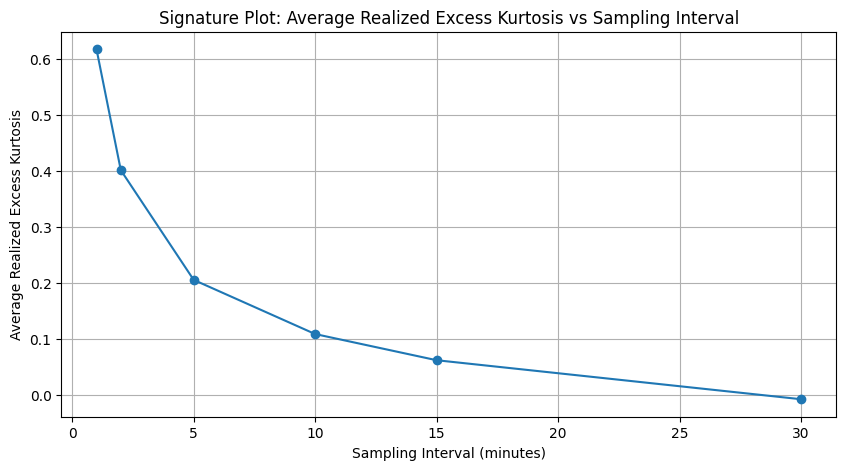

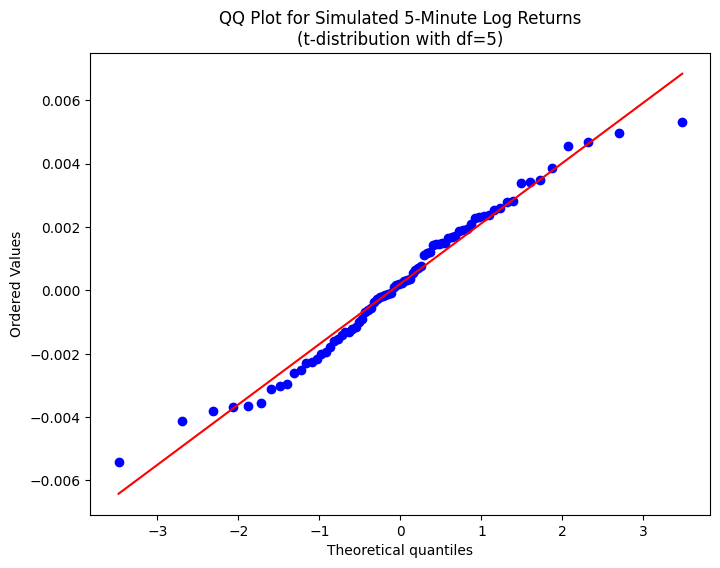

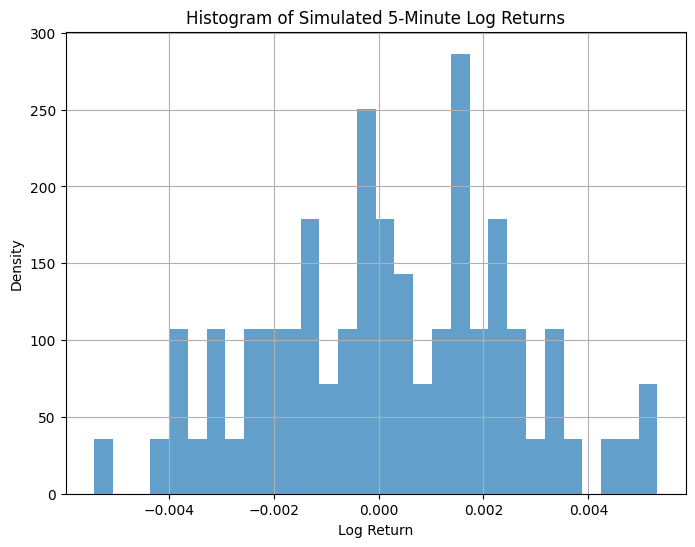

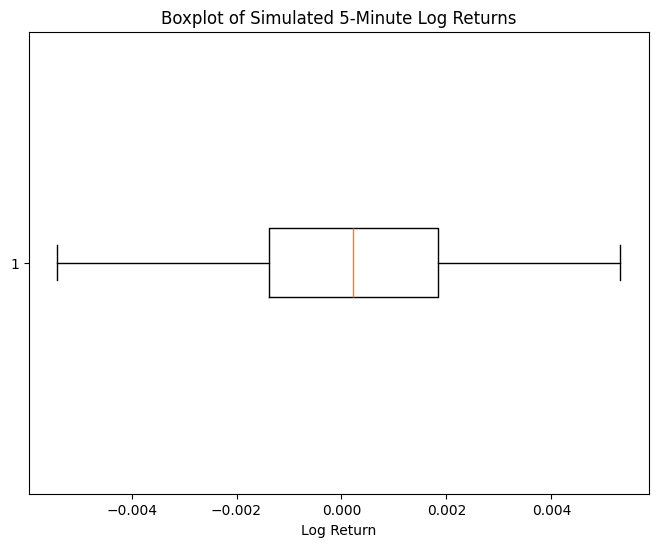

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy import stats

# Monte Carlo simulation parameters
num_paths = 5000      # number of simulated paths
N = 390               # number of minutes in one trading day (approximation)
dt = 1.0              # time step (1 minute)

# Parameters for the continuous (diffusive) part:
mu = 0.0              # drift (per minute)
sigma = 0.001         # volatility per minute (~daily volatility of ~2% over 390 minutes)

# Parameters for the jump component:
lambda_jump = 0.001   # jump intensity per minute (~0.39 jumps per day on average)
jump_mean = 0.0       # average jump size
jump_std = 0.005      # jump size standard deviation

# Microstructure noise standard deviation:
noise_std = 0.0005

def simulate_path(N, mu, sigma, lambda_jump, jump_mean, jump_std, noise_std):
    """
    Simulate a log-price path with jump-diffusion dynamics and add microstructure noise.
    Returns the observed price path (in levels) over N+1 time points.
    """
    logP = np.zeros(N+1)
    for t in range(N):
        dW = np.random.normal(0, np.sqrt(dt))
        # Poisson jump: number of jumps in dt:
        dN = np.random.poisson(lambda_jump * dt)
        jump = np.sum(np.random.normal(jump_mean, jump_std, size=dN)) if dN > 0 else 0.0
        logP[t+1] = logP[t] + mu*dt + sigma*dW + jump
    # Add microstructure noise:
    noise = np.random.normal(0, noise_std, size=N+1)
    observed_logP = logP + noise
    price = np.exp(observed_logP)
    return price

sampling_intervals = [1, 2, 5, 10, 15, 30]

# Dictionaries to store simulated skewness and kurtosis for different sampling intervals.
skew_results = {interval: [] for interval in sampling_intervals}
kurt_results = {interval: [] for interval in sampling_intervals}

for i in range(num_paths):
    price_path = simulate_path(N, mu, sigma, lambda_jump, jump_mean, jump_std, noise_std)
    # For each sampling interval, subsample the price path and compute log returns.
    for interval in sampling_intervals:
        indices = np.arange(0, len(price_path), interval)
        sampled_prices = price_path[indices]
        sampled_returns = np.diff(np.log(sampled_prices))
        if len(sampled_returns) > 0:
            rskew = skew(sampled_returns)
            # Using excess kurtosis (Fisher definition, where 0 corresponds to normal)
            rkurt = pd.Series(sampled_returns).kurtosis()
            skew_results[interval].append(rskew)
            kurt_results[interval].append(rkurt)

avg_skew = {interval: np.mean(skew_results[interval]) for interval in sampling_intervals}
avg_kurt = {interval: np.mean(kurt_results[interval]) for interval in sampling_intervals}

print("Average Realized Skewness by Sampling Frequency:")
for interval in sampling_intervals:
    print(f"Interval {interval} minute(s): {avg_skew[interval]:.4f}")

print("\nAverage Realized Excess Kurtosis by Sampling Frequency:")
for interval in sampling_intervals:
    print(f"Interval {interval} minute(s): {avg_kurt[interval]:.4f}")

# Signature plots for average realized skewness and excess kurtosis
plt.figure(figsize=(10,5))
plt.plot(sampling_intervals, [avg_skew[x] for x in sampling_intervals], marker='o')
plt.title("Signature Plot: Average Realized Skewness vs Sampling Interval")
plt.xlabel("Sampling Interval (minutes)")
plt.ylabel("Average Realized Skewness")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(sampling_intervals, [avg_kurt[x] for x in sampling_intervals], marker='o')
plt.title("Signature Plot: Average Realized Excess Kurtosis vs Sampling Interval")
plt.xlabel("Sampling Interval (minutes)")
plt.ylabel("Average Realized Excess Kurtosis")
plt.grid(True)
plt.show()

# --- Additional Distribution Analysis for Simulated Data ---
# For one simulated path, take sampling interval = 5 minutes and generate a QQ plot against a t-distribution.
test_path = simulate_path(N, mu, sigma, lambda_jump, jump_mean, jump_std, noise_std)
indices = np.arange(0, len(test_path), 5)
sampled_prices = test_path[indices]
sampled_returns = np.diff(np.log(sampled_prices))

plt.figure(figsize=(8,6))
# Here we use a t-distribution with an assumed degree of freedom (say, 5) as an example.
stats.probplot(sampled_returns, dist="t", sparams=(5,), plot=plt)
plt.title("QQ Plot for Simulated 5-Minute Log Returns\n(t-distribution with df=5)")
plt.show()

# Plot histogram and boxplot for the sampled 5-minute returns
plt.figure(figsize=(8,6))
plt.hist(sampled_returns, bins=30, alpha=0.7, density=True)
plt.title("Histogram of Simulated 5-Minute Log Returns")
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,6))
plt.boxplot(sampled_returns, vert=False)
plt.title("Boxplot of Simulated 5-Minute Log Returns")
plt.xlabel("Log Return")
plt.show()
